In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import joblib as jl

In [2]:
df = pd.read_csv("data/Nigeria_house_price_dataset.csv")
df = df.sample(frac=1, ignore_index=True, random_state=42)
print(df.shape)
df.head()

(23058, 11)


,bedrooms,bathrooms,toilets,parking_space,title,town,state,price,lat,lon,town_state
0,4,4,5,4,Detached Duplex,Ikoyi,Lagos,280000000.0,6.456061,3.442218,"Ikoyi, Lagos"
1,3,5,5,4,Terraced Duplexes,Ajah,Lagos,40000000.0,6.469472,3.562386,"Ajah, Lagos"
2,5,5,6,6,Detached Duplex,Magodo,Lagos,160000000.0,6.618081,3.377782,"Magodo, Lagos"
3,4,4,4,3,Terraced Duplexes,Abeokuta South,Ogun,28000000.0,7.156137,3.348967,"Abeokuta South, Ogun"
4,4,4,5,5,Detached Duplex,Ikoyi,Lagos,750000000.0,6.456061,3.442218,"Ikoyi, Lagos"


In [3]:
df.isnull().sum()

bedrooms         0
bathrooms        0
toilets          0
parking_space    0
title            0
town             0
state            0
price            0
lat              0
lon              0
town_state       0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23058 entries, 0 to 23057
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       23058 non-null  int64  
 1   bathrooms      23058 non-null  int64  
 2   toilets        23058 non-null  int64  
 3   parking_space  23058 non-null  int64  
 4   title          23058 non-null  object 
 5   town           23058 non-null  object 
 6   state          23058 non-null  object 
 7   price          23058 non-null  float64
 8   lat            23058 non-null  float64
 9   lon            23058 non-null  float64
 10  town_state     23058 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 1.9+ MB


In [5]:
df.nunique()

bedrooms           9
bathrooms          9
toilets            9
parking_space      9
title              7
town             128
state              5
price            529
lat              128
lon              128
town_state       130
dtype: int64

In [6]:
df.duplicated().sum()

10360

In [7]:
df = df.drop_duplicates()

In [8]:
df.duplicated().sum()

0

In [9]:
df.shape

(12698, 11)

In [10]:
df["price"] = round(df["price"] / 1000000, 2)
df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price,lat,lon,town_state
0,4,4,5,4,Detached Duplex,Ikoyi,Lagos,280.0,6.456061,3.442218,"Ikoyi, Lagos"
1,3,5,5,4,Terraced Duplexes,Ajah,Lagos,40.0,6.469472,3.562386,"Ajah, Lagos"
2,5,5,6,6,Detached Duplex,Magodo,Lagos,160.0,6.618081,3.377782,"Magodo, Lagos"
3,4,4,4,3,Terraced Duplexes,Abeokuta South,Ogun,28.0,7.156137,3.348967,"Abeokuta South, Ogun"
4,4,4,5,5,Detached Duplex,Ikoyi,Lagos,750.0,6.456061,3.442218,"Ikoyi, Lagos"


In [11]:
df.describe()

,bedrooms,bathrooms,toilets,parking_space,price,lat,lon
count,12698.000000,12698.000000,12698.000000,12698.000000,1.269800e+04,12698.000000,12698.000000
mean,4.208143,4.543944,5.043471,4.068357,4.319258e+02,7.080635,4.590915
std,1.296510,1.337036,1.396166,1.646059,1.688872e+04,1.173093,1.752055
min,1.000000,1.000000,1.000000,1.000000,9.000000e-02,4.767658,2.881320
25%,3.000000,4.000000,4.000000,3.000000,4.000000e+01,6.458985,3.442218
50%,4.000000,5.000000,5.000000,4.000000,7.800000e+01,6.469472,3.601521
75%,5.000000,5.000000,6.000000,5.000000,1.700000e+02,6.949996,7.018853
max,9.000000,9.000000,9.000000,9.000000,1.800000e+06,9.285590,7.876834


C:\Users\Nenchi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


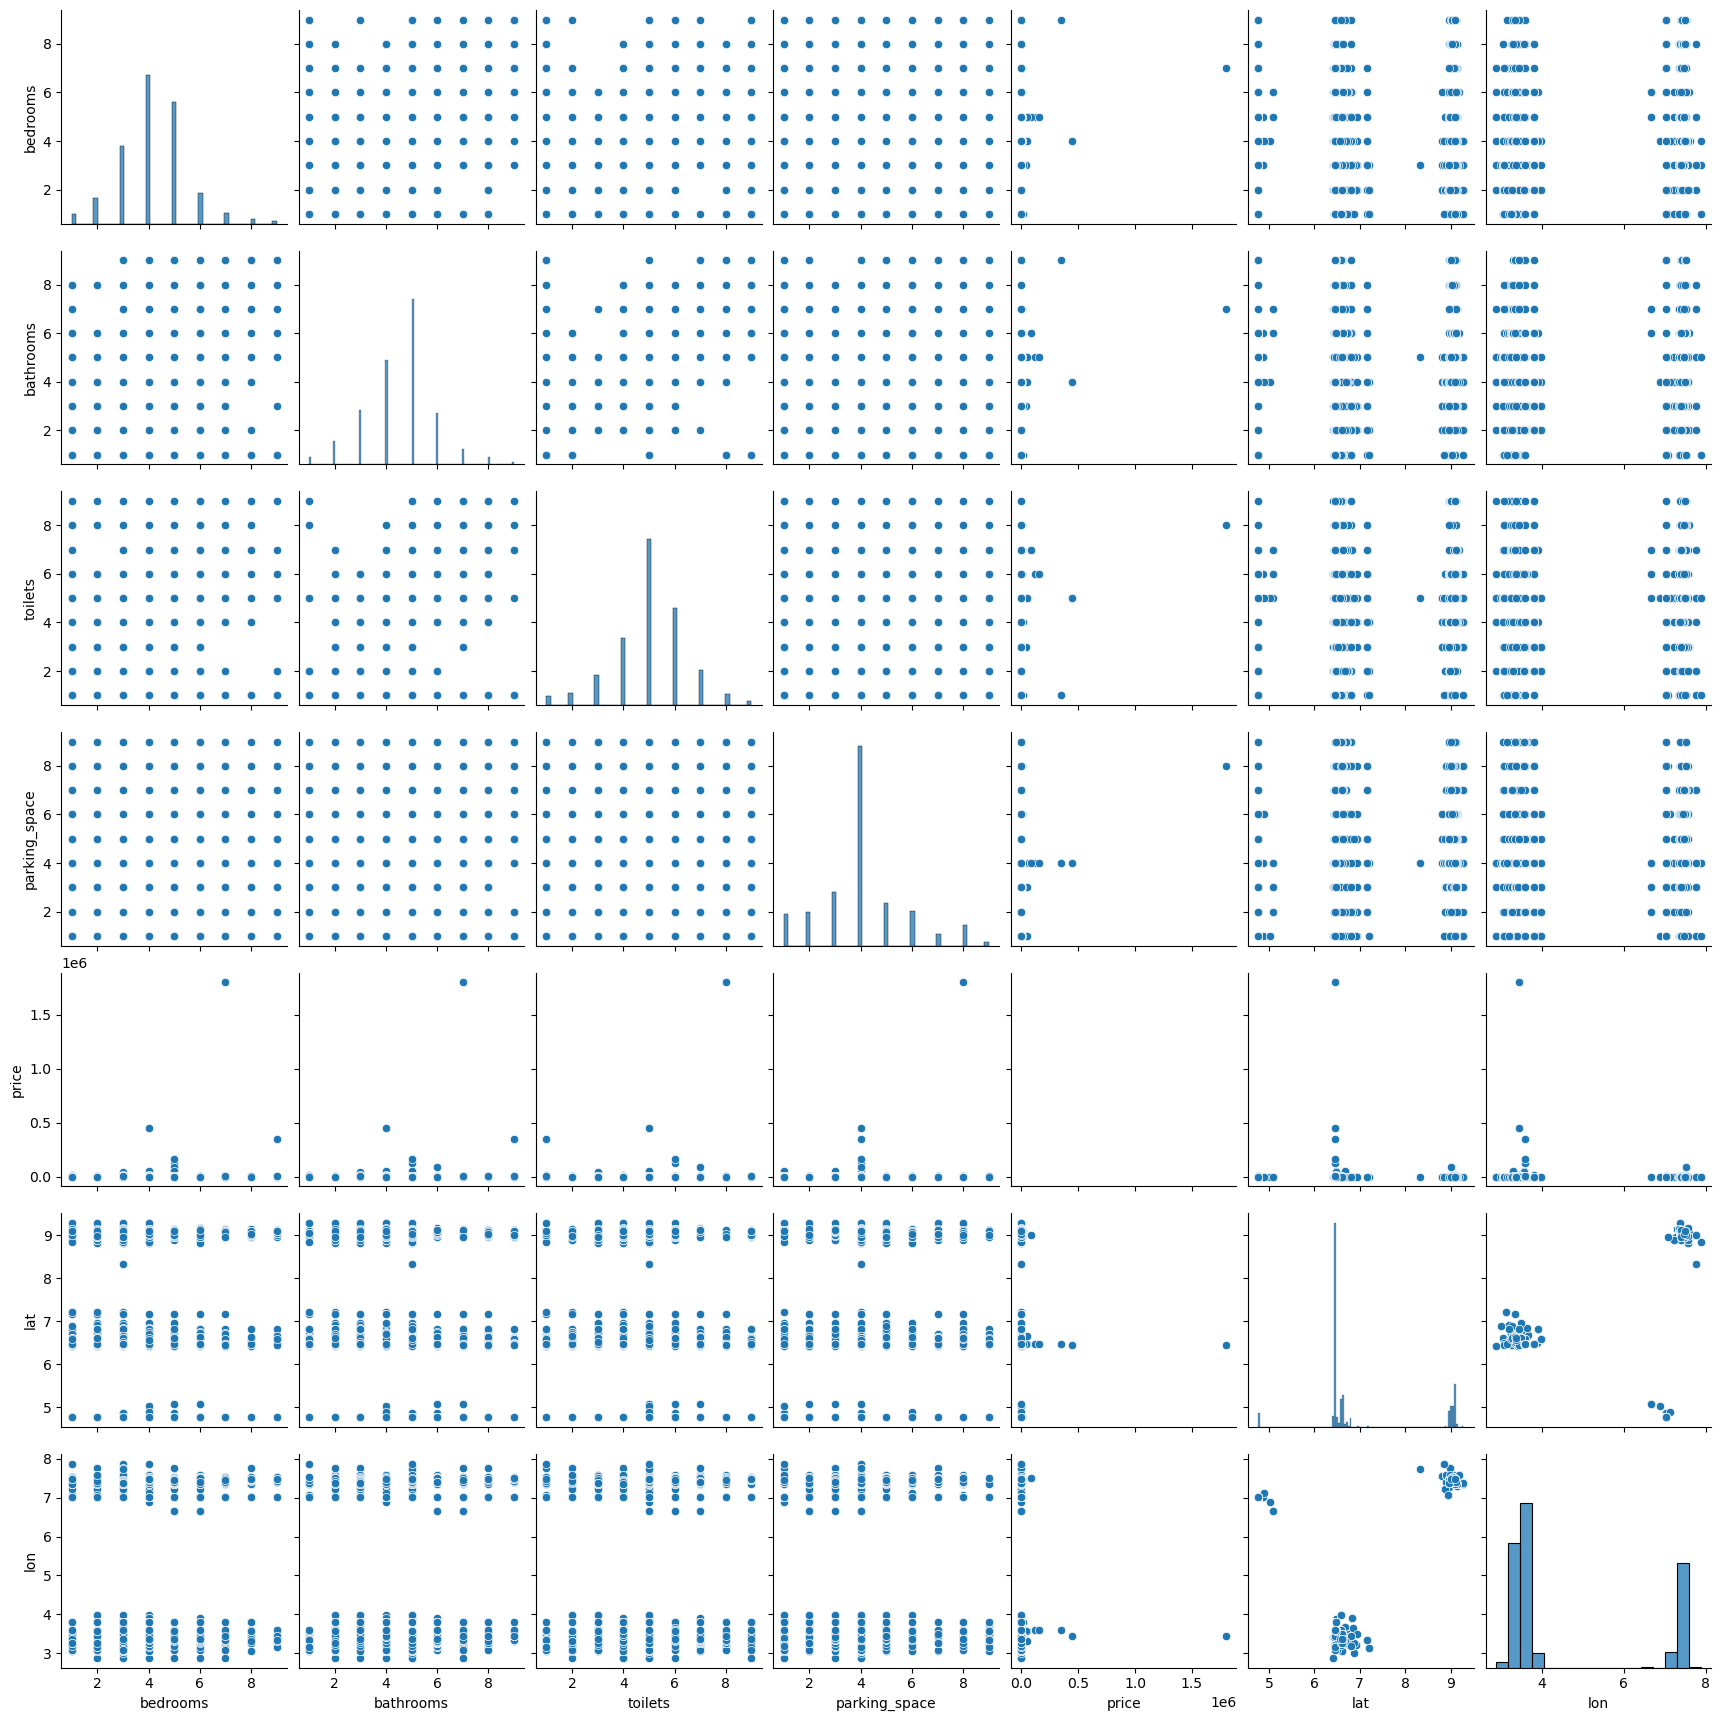

In [12]:
sns.pairplot(df)

C:\Users\Nenchi\AppData\Local\Temp\ipykernel_5864\50337492.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["price"])


<Axes: xlabel='price', ylabel='Density'>

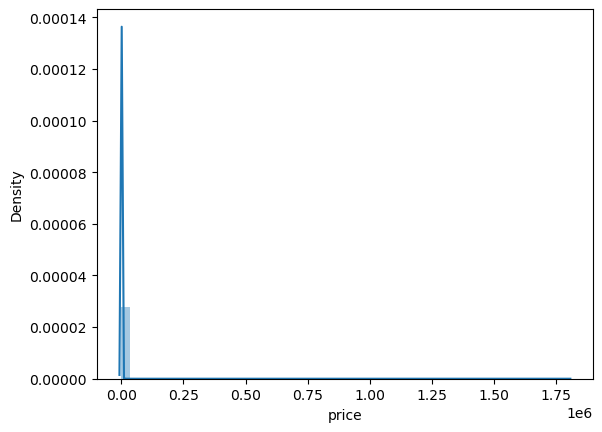

In [13]:
sns.distplot(df["price"])

In [14]:
def outlier_remover(data, column):
    """Removes outlier using IQR technique"""
    Q1, Q3 = data[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    clean_data = data[(data[column] > lower_limit) & (data[column] < upper_limit)]
    return clean_data

In [15]:
clean_df = outlier_remover(df, "price")

C:\Users\Nenchi\AppData\Local\Temp\ipykernel_5864\3966218922.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clean_df["price"])


<Axes: xlabel='price', ylabel='Density'>

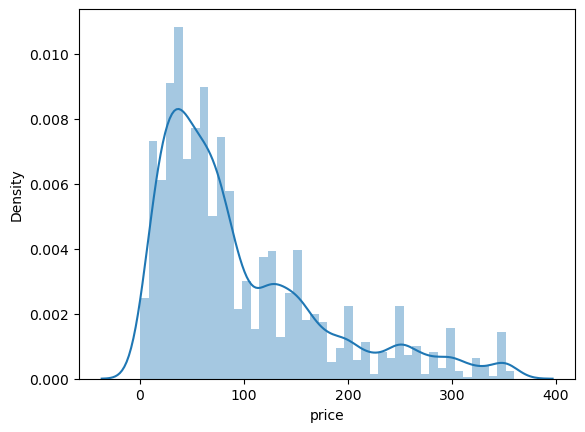

In [16]:
sns.distplot(clean_df["price"])

In [17]:
clean_df.describe()

,bedrooms,bathrooms,toilets,parking_space,price,lat,lon
count,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000,11367.000000
mean,4.084631,4.449547,4.963051,4.056215,95.297064,7.058696,4.570815
std,1.200863,1.261471,1.308901,1.604999,79.689167,1.164283,1.736637
min,1.000000,1.000000,1.000000,1.000000,0.090000,4.767658,2.881320
25%,3.000000,4.000000,4.000000,3.000000,36.000000,6.458985,3.436720
50%,4.000000,5.000000,5.000000,4.000000,70.000000,6.471125,3.601521
75%,5.000000,5.000000,6.000000,5.000000,130.000000,6.814910,7.018853
max,9.000000,9.000000,9.000000,9.000000,360.000000,9.285590,7.876834


In [18]:
nasarawa = clean_df[clean_df["state"] == "Nasarawa"]
nasarawa.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price,lat,lon,town_state
2728,8,8,1,7,Block of Flats,Karu,Nasarawa,12.0,8.995008,7.751226,"Karu, Nasarawa"
11051,3,3,4,3,Detached Bungalow,Karu,Nasarawa,9.0,8.995008,7.751226,"Karu, Nasarawa"
13060,2,5,5,1,Detached Bungalow,Karu,Nasarawa,3.0,8.995008,7.751226,"Karu, Nasarawa"
19503,1,1,1,4,Semi Detached Bungalow,Keffi,Nasarawa,40.0,8.845318,7.876834,"Keffi, Nasarawa"
19671,3,5,5,4,Detached Duplex,Keffi,Nasarawa,45.0,8.845318,7.876834,"Keffi, Nasarawa"


In [19]:
avg_price_by_town = nasarawa.drop(columns=["title", "state", "town_state", "bedrooms", "bathrooms", "toilets", "lat", "lon",
                                        "parking_space"]).groupby(["town"], group_keys=True).mean()
avg_price_by_town.reset_index(inplace=True)
avg_price_by_town.head(10)

,town,price
0,Karu,17.200000
1,Keffi,73.333333
2,Nasarawa,15.000000


In [20]:
ogun = clean_df[clean_df["state"] == "Ogun"]
ogun.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price,lat,lon,town_state
3,4,4,4,3,Terraced Duplexes,Abeokuta South,Ogun,28.0,7.156137,3.348967,"Abeokuta South, Ogun"
31,3,3,4,4,Detached Bungalow,Isheri North,Ogun,4.0,6.641042,3.371756,"Isheri North, Ogun"
32,6,7,8,5,Block of Flats,Ifo,Ogun,25.0,6.814910,3.195180,"Ifo, Ogun"
45,4,5,5,4,Block of Flats,Ogijo,Ogun,15.0,6.699425,3.515509,"Ogijo, Ogun"
77,3,3,3,3,Detached Bungalow,Mowe Ofada,Ogun,9.5,6.808549,3.436720,"Mowe Ofada, Ogun"


In [21]:
avg_price_by_town = ogun.drop(columns=["title", "state", "town_state", "bedrooms", "bathrooms", "toilets", "lat", "lon",
                                        "parking_space"]).groupby(["town"], group_keys=True).mean()
avg_price_by_town.reset_index(inplace=True)
avg_price_by_town.head(10)

,town,price
0,Abeokuta North,28.800000
1,Abeokuta South,35.645161
2,Ado-Odo/Ota,19.938235
3,Agbara,13.000000
4,Arepo,48.162794
5,Ewekoro,67.500000
6,Ibafo,20.690476
7,Ifo,21.328125
8,Ijebu Ode,19.666667
9,Ijoko,49.800000


In [22]:
rivers = clean_df[clean_df["state"] == "Rivers"]
rivers.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price,lat,lon,town_state
131,3,3,4,4,Detached Bungalow,Port Harcourt,Rivers,40.0,4.767658,7.018853,"Port Harcourt, Rivers"
136,3,3,4,1,Detached Bungalow,Port Harcourt,Rivers,6.0,4.767658,7.018853,"Port Harcourt, Rivers"
218,4,4,5,4,Detached Bungalow,Port Harcourt,Rivers,20.0,4.767658,7.018853,"Port Harcourt, Rivers"
257,4,4,6,5,Semi Detached Bungalow,Port Harcourt,Rivers,30.0,4.767658,7.018853,"Port Harcourt, Rivers"
258,3,3,4,4,Detached Bungalow,Port Harcourt,Rivers,33.0,4.767658,7.018853,"Port Harcourt, Rivers"


In [23]:
avg_price_by_town = rivers.drop(columns=["title", "state", "town_state", "bedrooms", "bathrooms", "toilets", "lat", "lon",
                                        "parking_space"]).groupby(["town"], group_keys=True).mean()
avg_price_by_town.reset_index(inplace=True)
avg_price_by_town.head(10)

,town,price
0,Eleme,45.750000
1,Ikwerre,20.000000
2,Obio-Akpor,57.500000
3,Oyigbo,25.000000
4,Port Harcourt,76.874211


In [24]:
abuja = clean_df[clean_df["state"] == "Abuja"]
abuja.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price,lat,lon,town_state
5,4,4,5,4,Semi Detached Duplex,Gwarinpa,Abuja,85.0,9.109821,7.392965,"Gwarinpa, Abuja"
16,6,6,7,4,Detached Duplex,Gwarinpa,Abuja,78.0,9.109821,7.392965,"Gwarinpa, Abuja"
27,3,4,4,4,Detached Duplex,Lokogoma District,Abuja,18.0,8.968154,7.464076,"Lokogoma District, Abuja"
49,3,3,4,3,Terraced Duplexes,Gwarinpa,Abuja,26.0,9.109821,7.392965,"Gwarinpa, Abuja"
50,5,4,5,4,Detached Duplex,Gwarinpa,Abuja,140.0,9.109821,7.392965,"Gwarinpa, Abuja"


C:\Users\Nenchi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


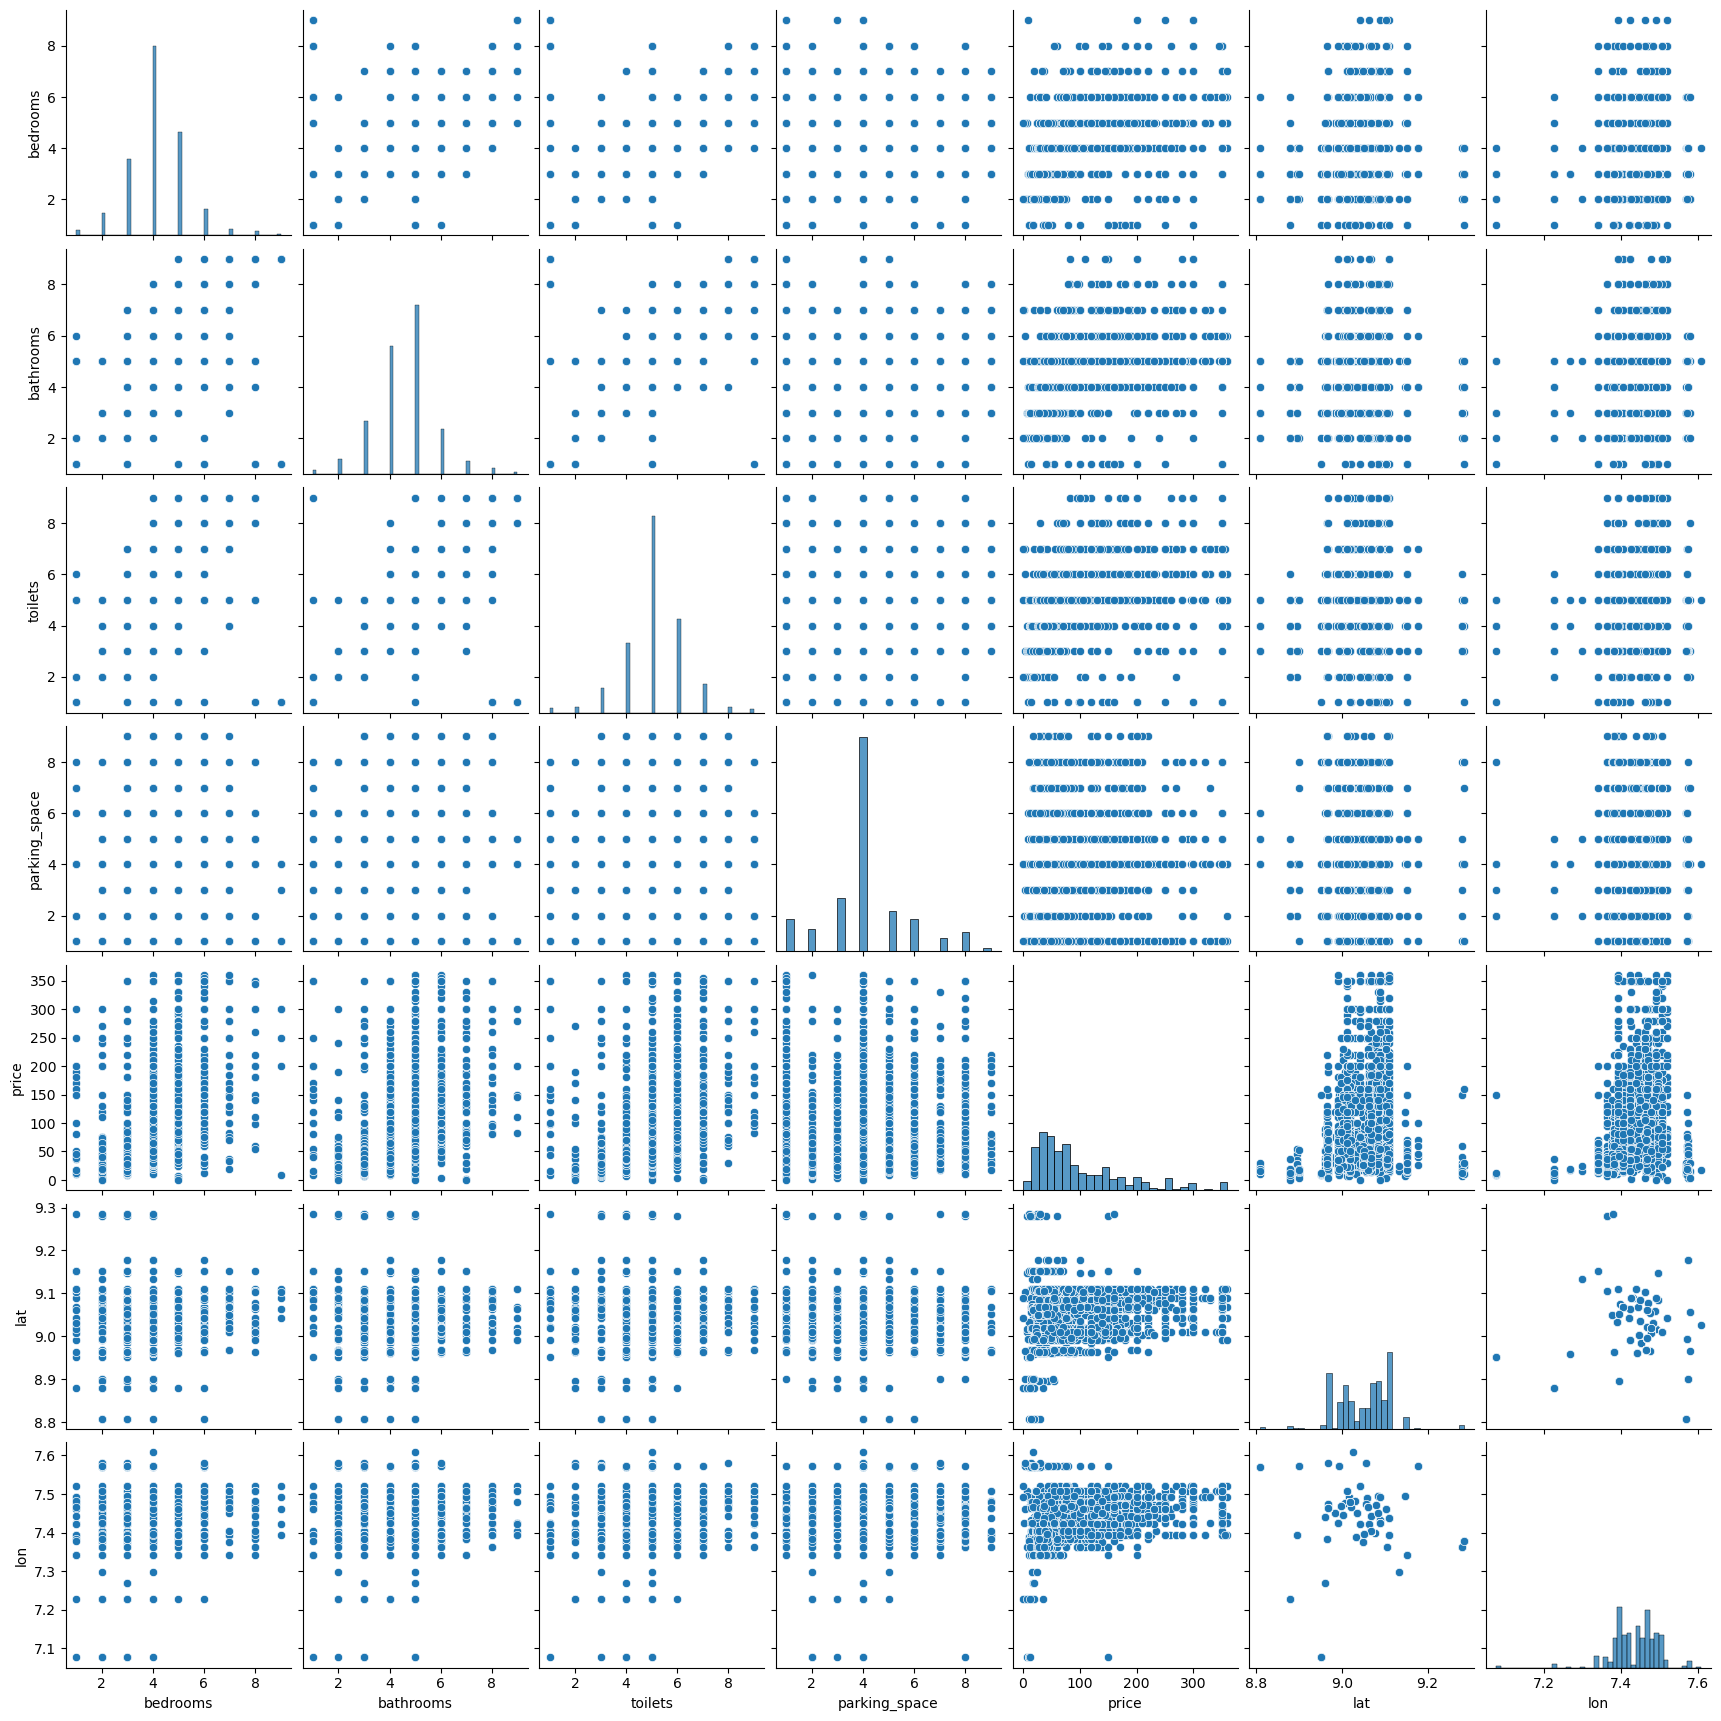

In [25]:
sns.pairplot(abuja)

In [26]:
avg_price_by_town = abuja.drop(columns=["title", "state", "town_state", "bedrooms", "bathrooms", "toilets", "lat", "lon",
                                        "parking_space"]).groupby(["town"], group_keys=True).mean()
avg_price_by_town.reset_index(inplace=True)
avg_price_by_town.head(10)

,town,price
0,Apo,83.007353
1,Asokoro District,190.949200
2,Bwari,37.625000
3,Central Business District,103.333333
4,Dakibiyu,35.083333
5,Dakwo,49.928571
6,Dape,54.000000
7,Dei-Dei,17.000000
8,Diplomatic Zones,95.600000
9,Duboyi,66.000000


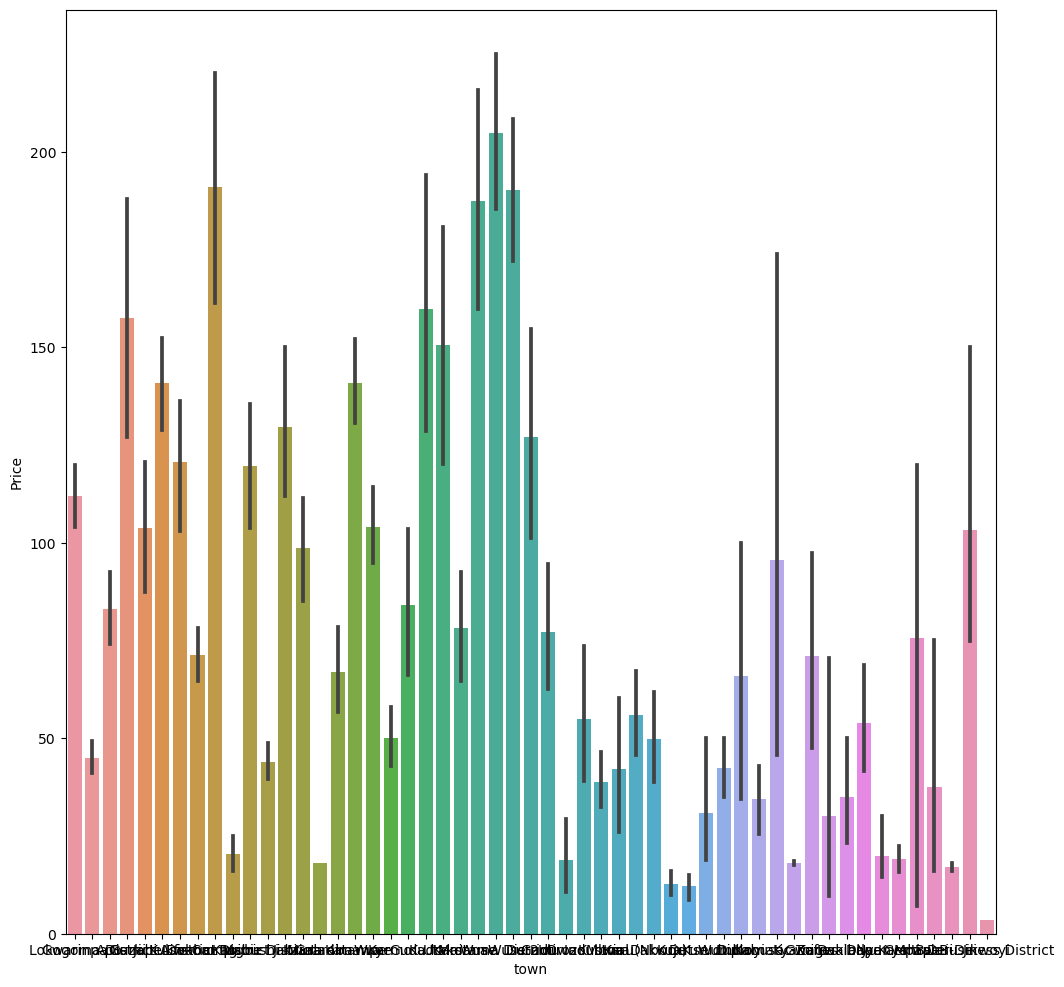

In [27]:
plt.figure(figsize=(12,12))
sns.barplot(data=abuja, x="town", y="price")
plt.xlabel("town")
plt.ylabel("Price")
plt.show()

In [28]:
sv = sweetviz.analyze(abuja)

                                             |                                             | [  0%]   00:00 ->…


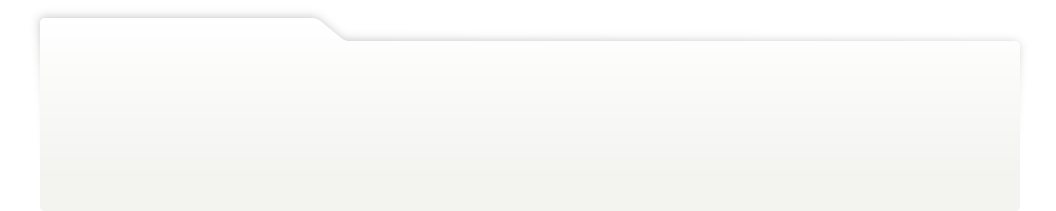
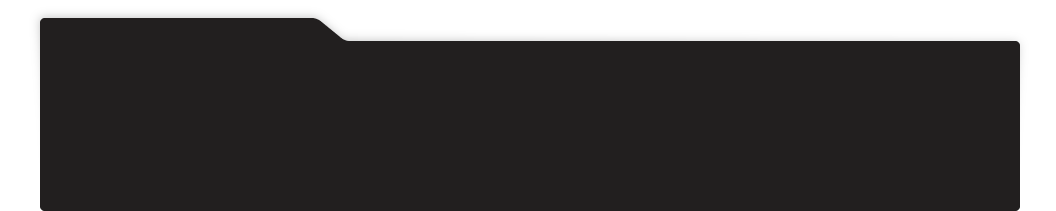
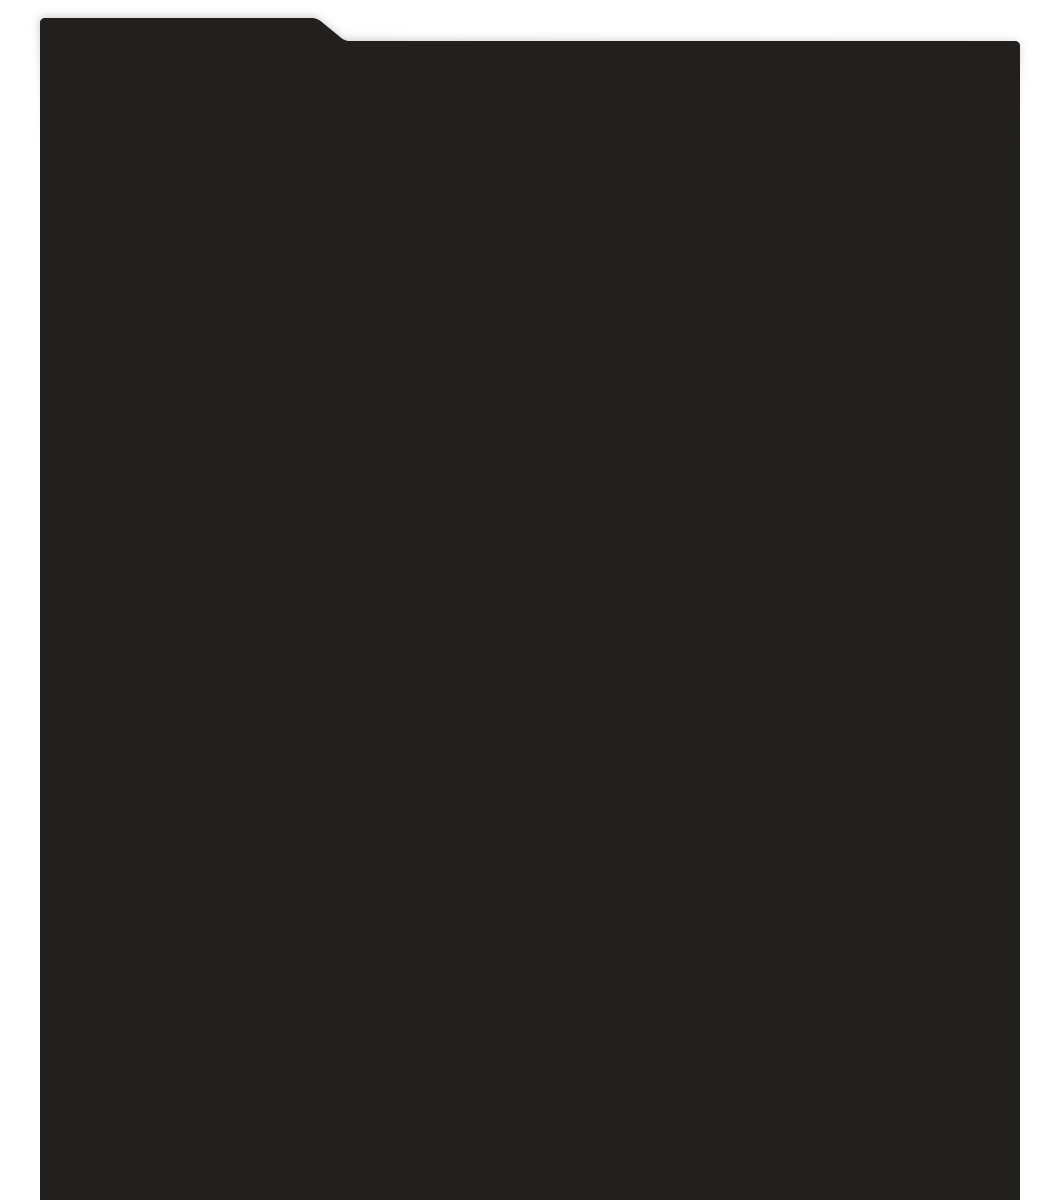
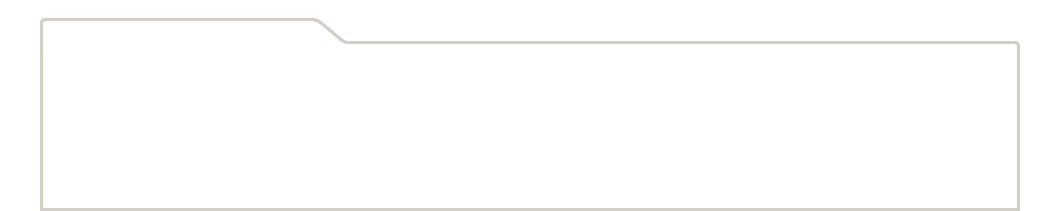
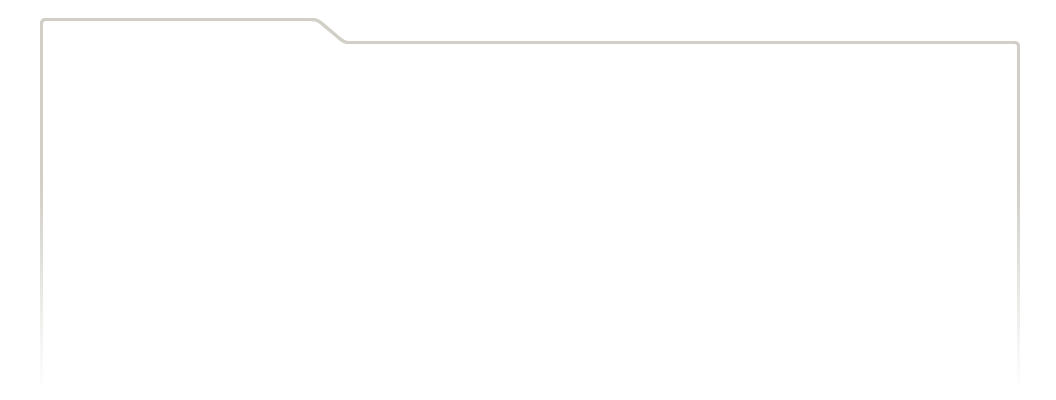
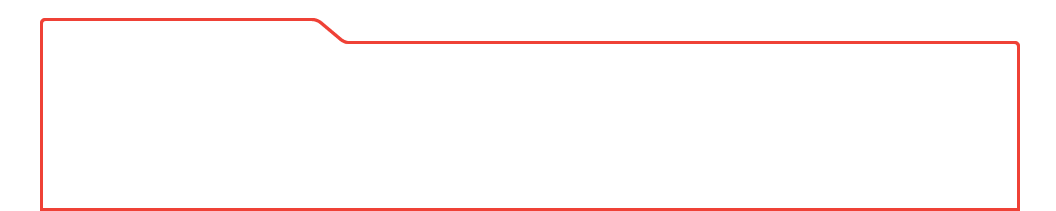
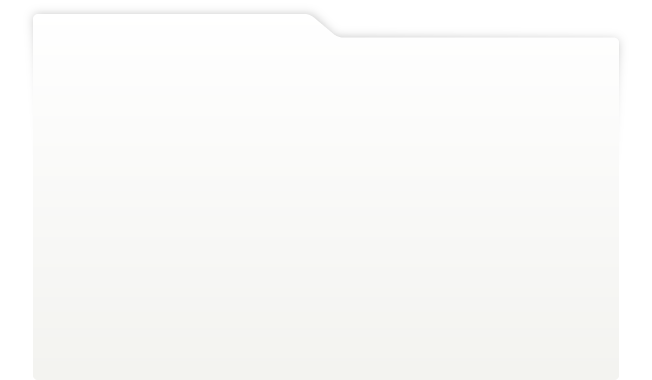
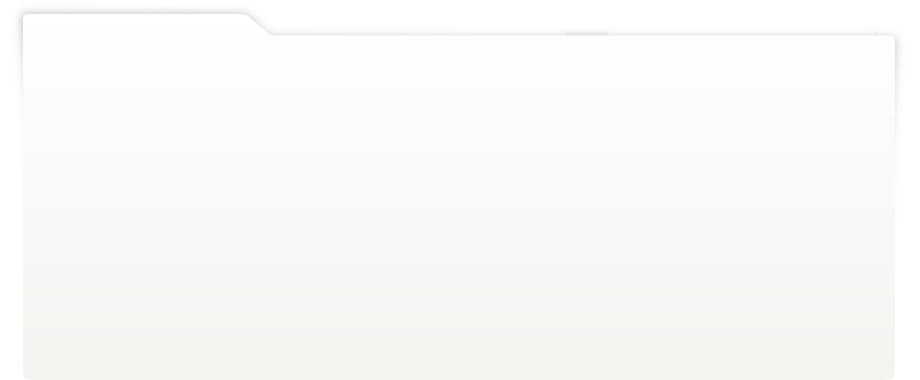
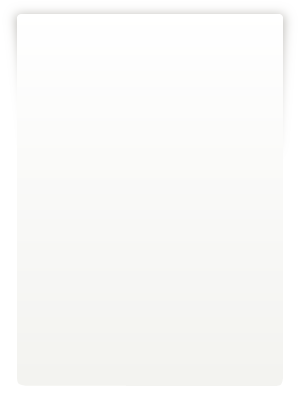
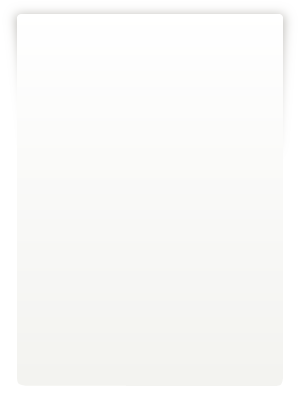
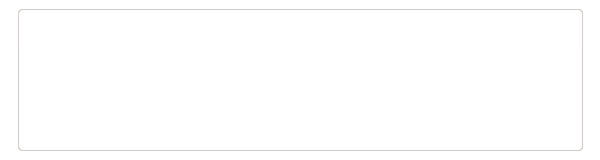
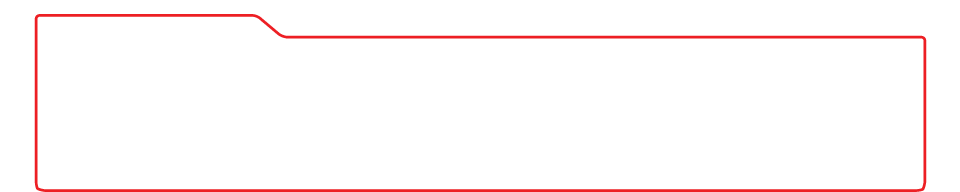
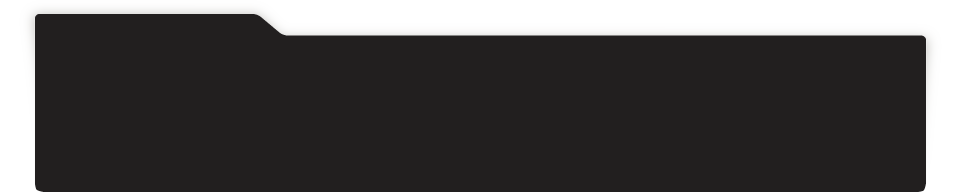
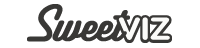
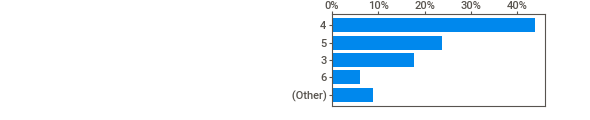
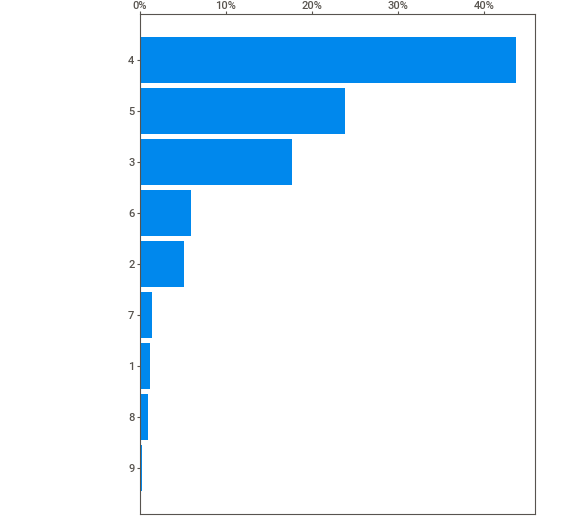
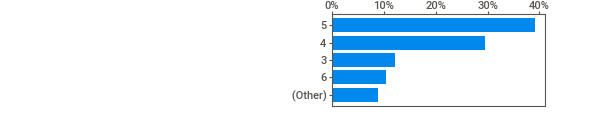
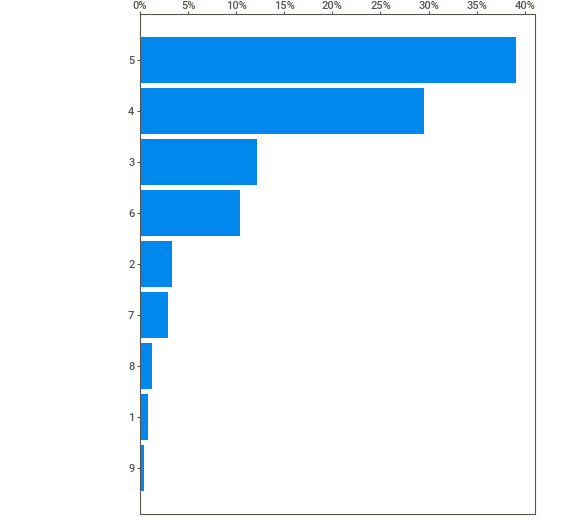
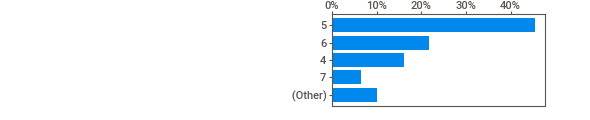
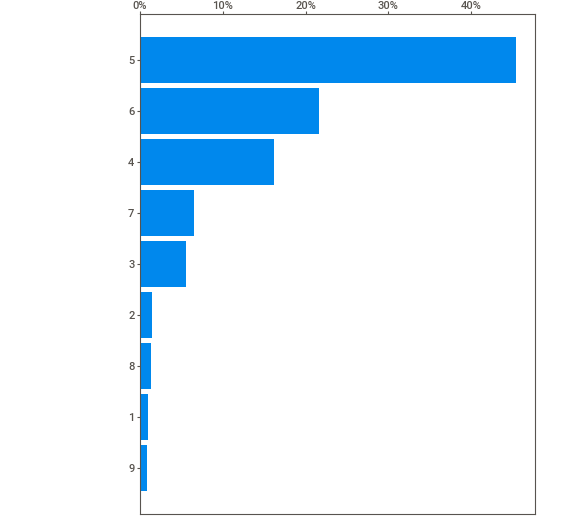
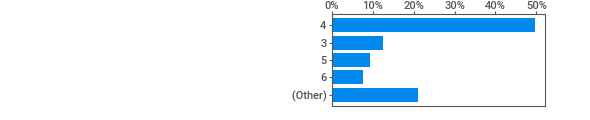
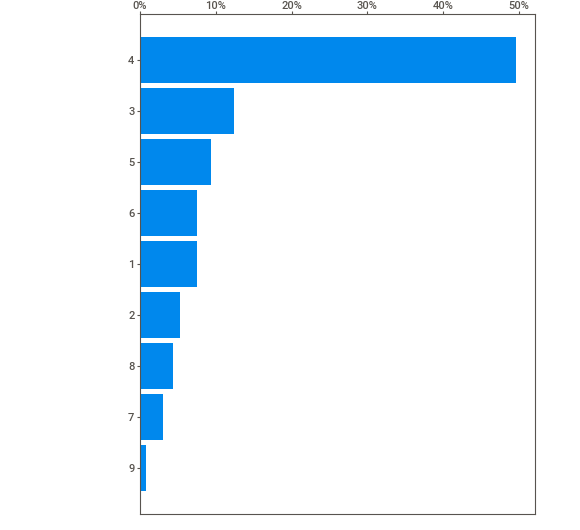
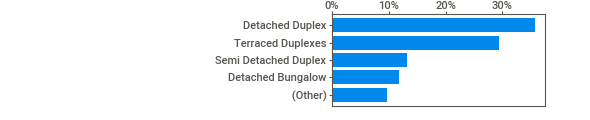
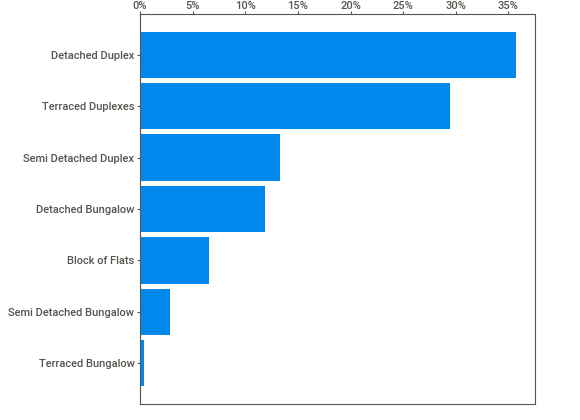
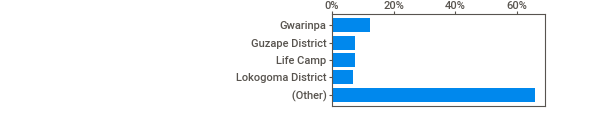
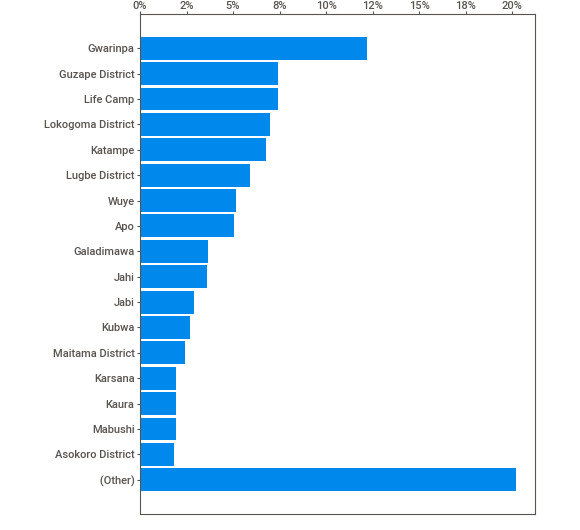
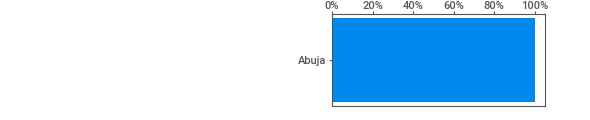
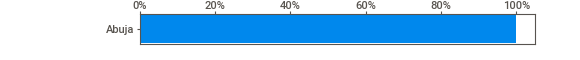
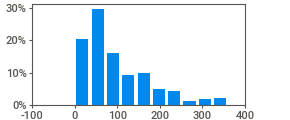
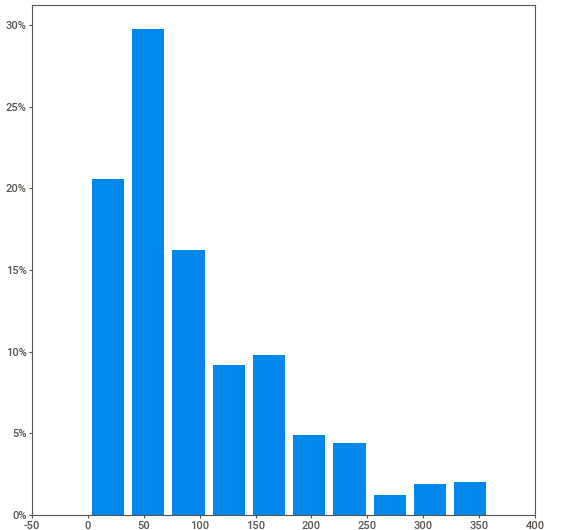
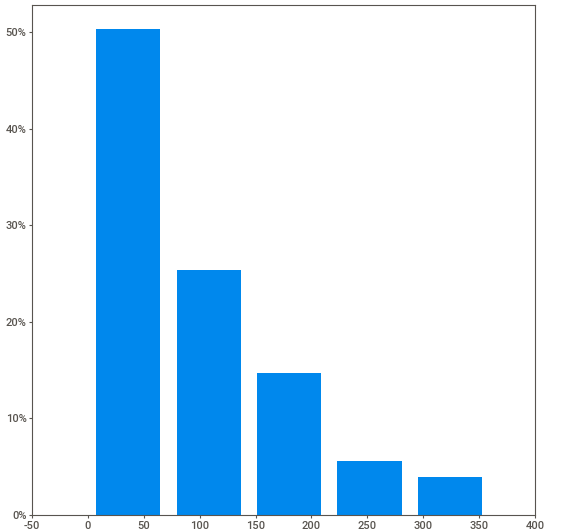
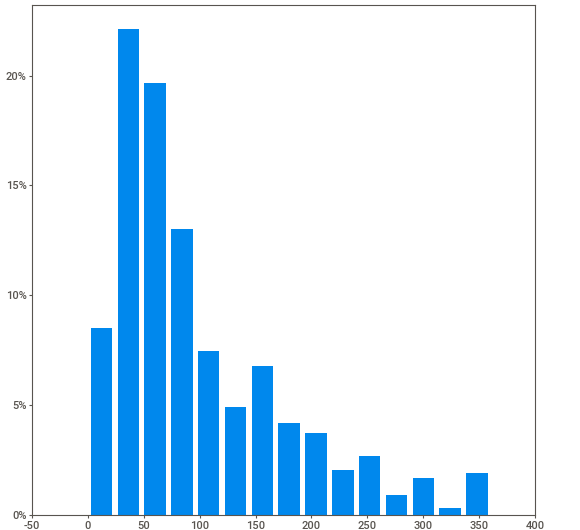
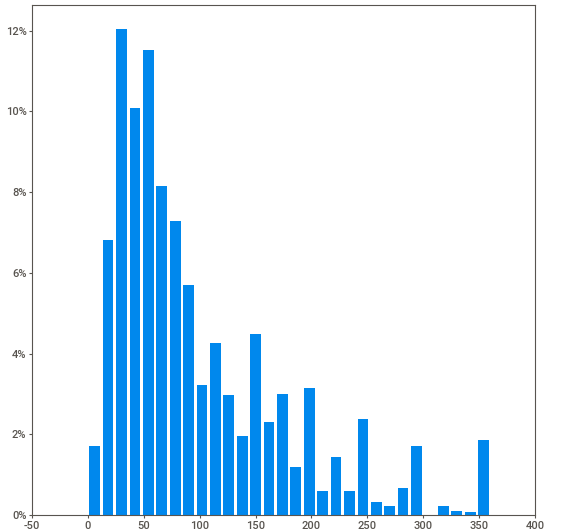
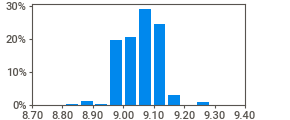
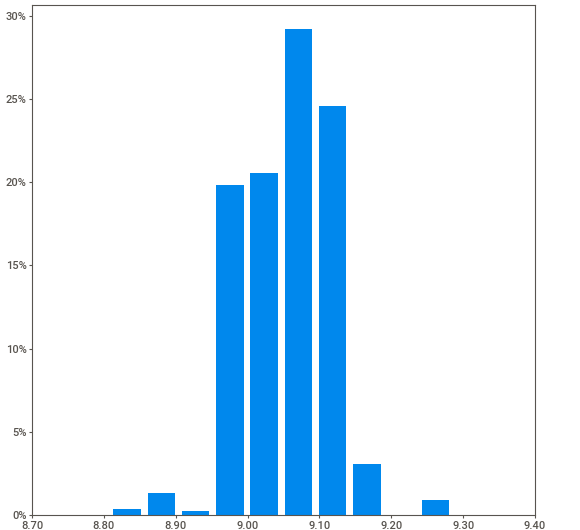
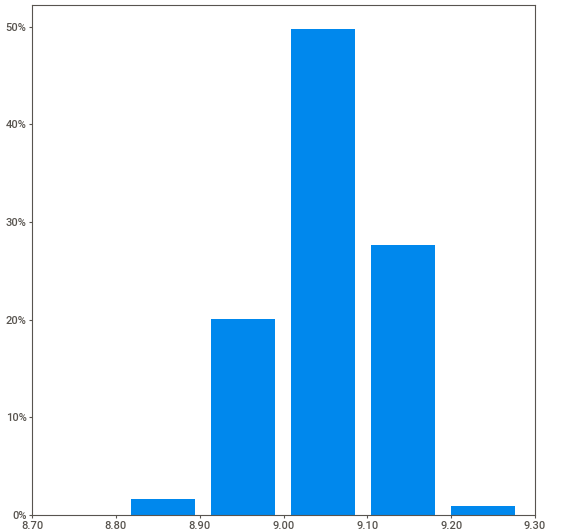
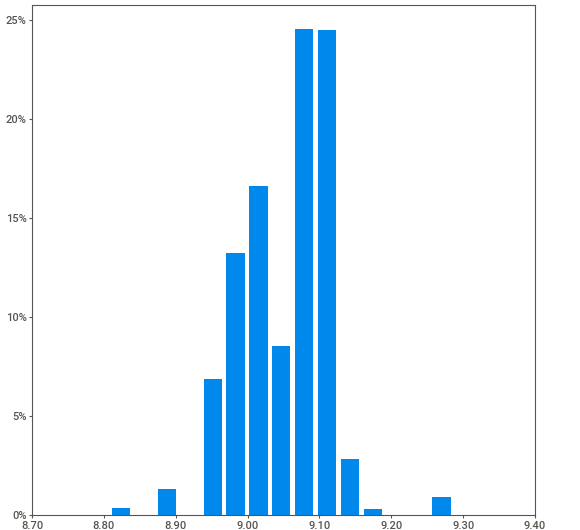
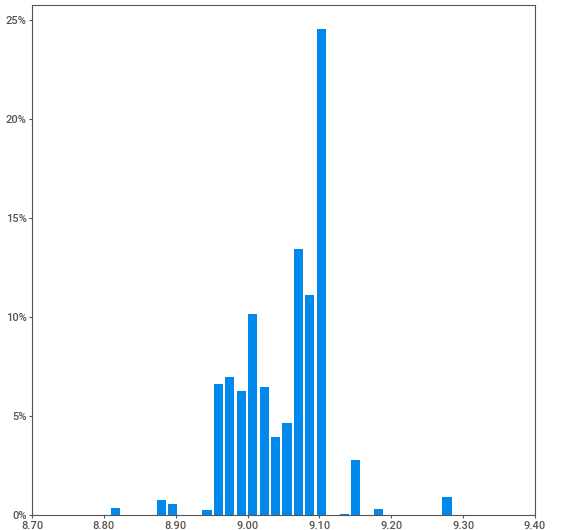
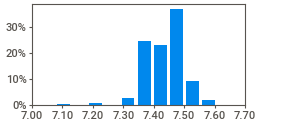
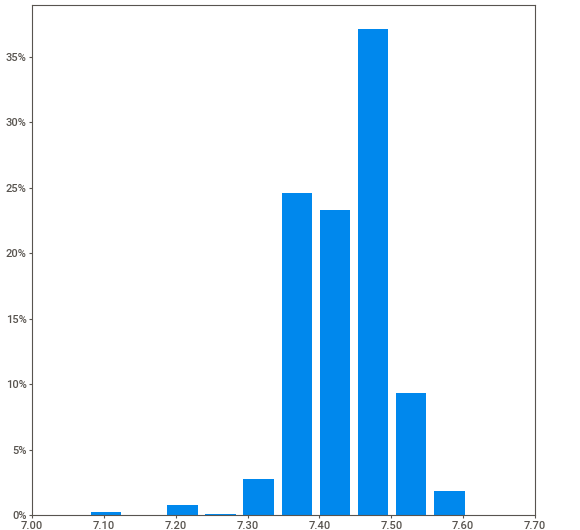
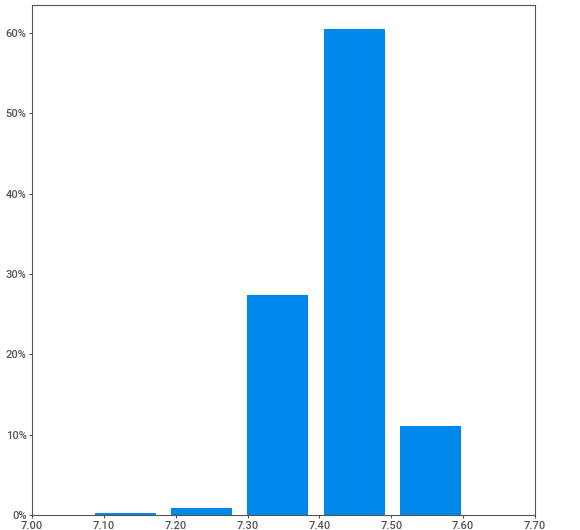
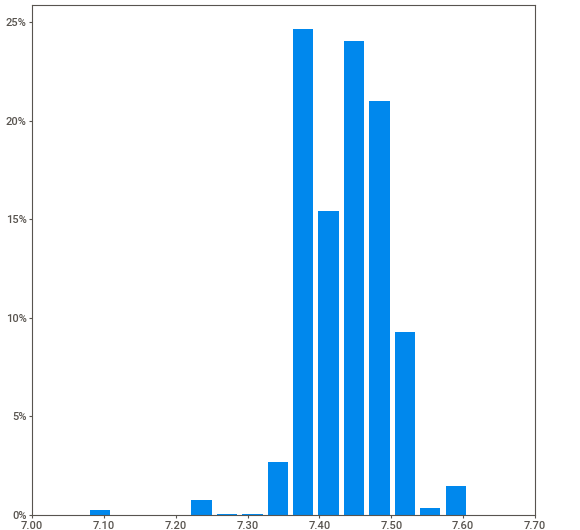
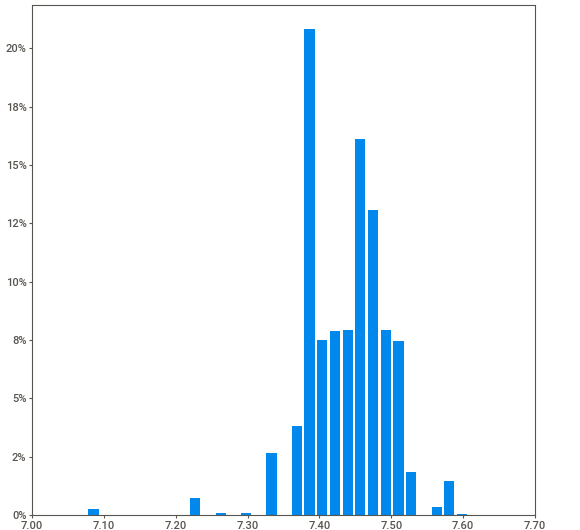
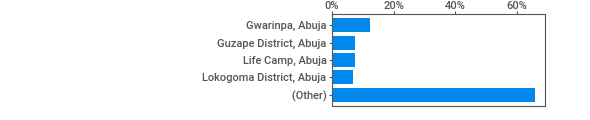
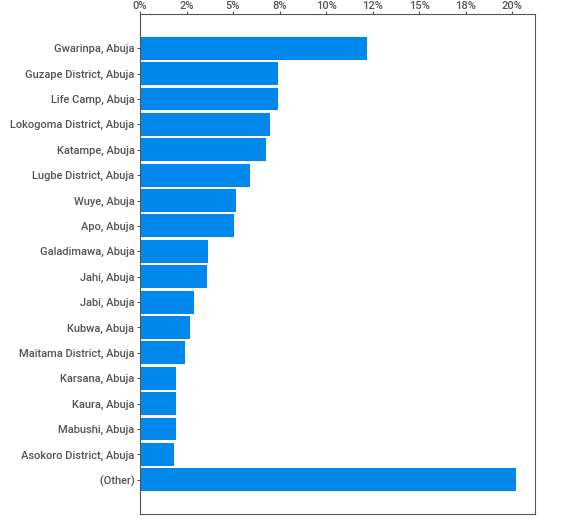
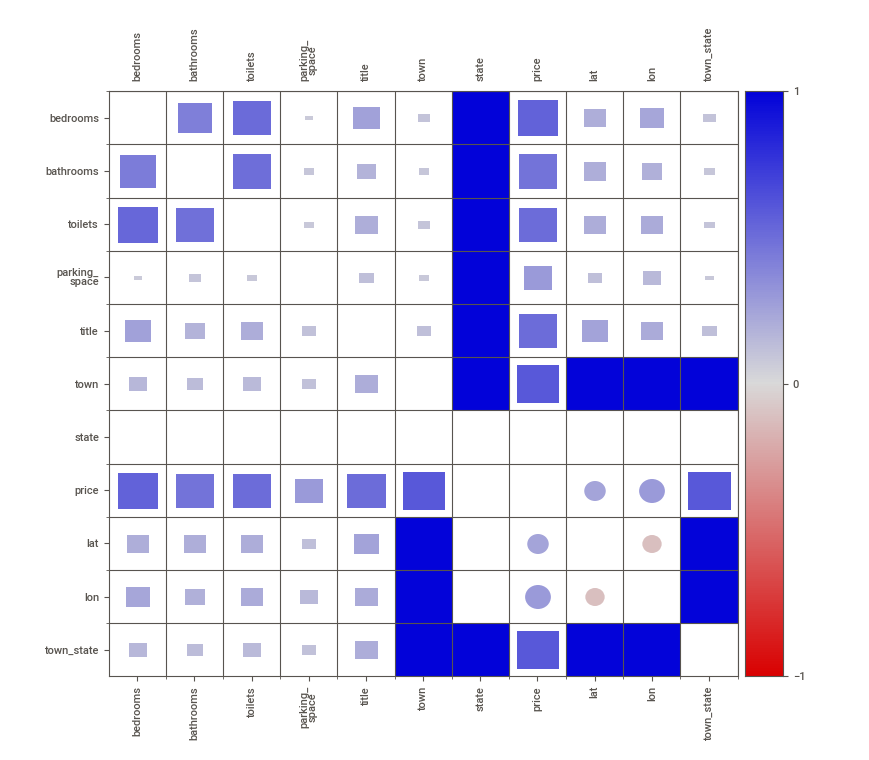
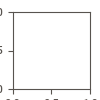

In [29]:
sv.show_notebook()

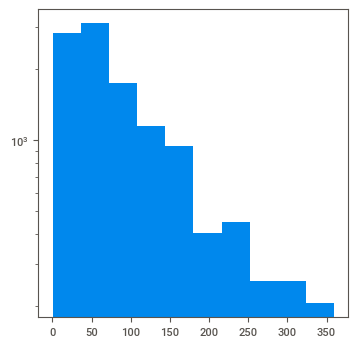

In [30]:
plt.figure(figsize=(4,4))
plt.hist(data=clean_df, x="price", log=True)
plt.show()

In [31]:
lower_limit, upper_limit = clean_df["price"].quantile([.10,.90])
print([lower_limit, upper_limit])

[20.0, 220.0]


In [32]:
cleaned_df = clean_df[(clean_df["price"]>lower_limit) & (clean_df["price"]<upper_limit)]

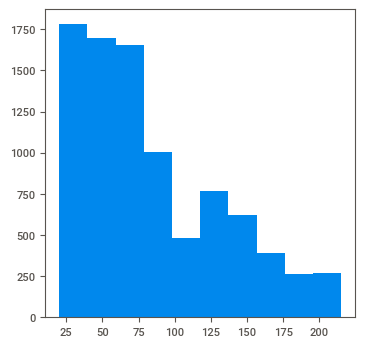

In [33]:
plt.figure(figsize=(4,4))
plt.hist(data=cleaned_df, x="price")
plt.show()

In [34]:
sorted(cleaned_df["title"].unique())

['Block of Flats',
 'Detached Bungalow',
 'Detached Duplex',
 'Semi Detached Bungalow',
 'Semi Detached Duplex',
 'Terraced Bungalow',
 'Terraced Duplexes']

In [35]:
main_df = cleaned_df.drop(["town", "state", "town_state"], axis=1)
main_df.head()

,bedrooms,bathrooms,toilets,parking_space,title,price,lat,lon
1,3,5,5,4,Terraced Duplexes,40.0,6.469472,3.562386
2,5,5,6,6,Detached Duplex,160.0,6.618081,3.377782
3,4,4,4,3,Terraced Duplexes,28.0,7.156137,3.348967
5,4,4,5,4,Semi Detached Duplex,85.0,9.109821,7.392965
6,5,5,6,6,Detached Duplex,170.0,6.596061,3.340787


In [36]:
encoder = LabelEncoder()

In [37]:
main_df["title"] = encoder.fit_transform(main_df[["title"]])
main_df.head()

C:\Users\Nenchi\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,bedrooms,bathrooms,toilets,parking_space,title,price,lat,lon
1,3,5,5,4,6,40.0,6.469472,3.562386
2,5,5,6,6,2,160.0,6.618081,3.377782
3,4,4,4,3,6,28.0,7.156137,3.348967
5,4,4,5,4,4,85.0,9.109821,7.392965
6,5,5,6,6,2,170.0,6.596061,3.340787


In [38]:
correl = main_df.corr()

<Axes: >

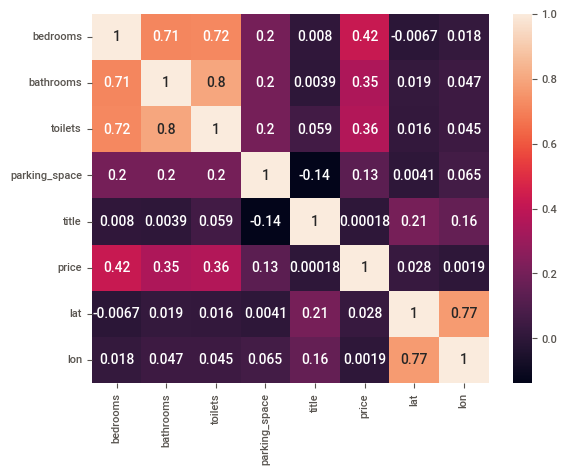

In [39]:
sns.heatmap(correl, annot=True, fmt=".2g")

In [45]:
X = main_df.drop(["price", "toilets", "bathrooms"], axis=1)
y = np.log(main_df["price"])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [47]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7143, 5)
(7143,)
(1786, 5)
(1786,)


In [48]:
X.columns

Index(['bedrooms', 'parking_space', 'title', 'lat', 'lon'], dtype='object')

C:\Users\Nenchi\AppData\Local\Temp\ipykernel_5864\2315493301.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


<Axes: xlabel='price', ylabel='Density'>

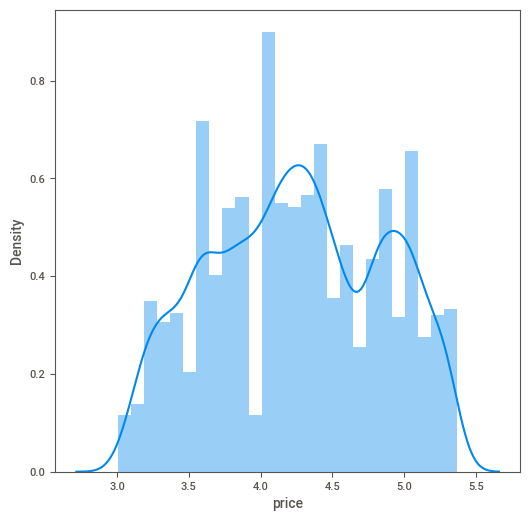

In [49]:
plt.figure(figsize=(6,6))
sns.distplot(y)

In [50]:
scaler = StandardScaler()

In [51]:
scaler.fit(X_train)

StandardScaler()

In [52]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
model_lr = LinearRegression()

In [54]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [55]:
model_lr.score(X_train, y_train)

0.20998323243224626

In [56]:
lagos = df[df["state"] == "Lagos"]
lagos.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price,lat,lon,town_state
0,4,4,5,4,Detached Duplex,Ikoyi,Lagos,280.0,6.456061,3.442218,"Ikoyi, Lagos"
1,3,5,5,4,Terraced Duplexes,Ajah,Lagos,40.0,6.469472,3.562386,"Ajah, Lagos"
2,5,5,6,6,Detached Duplex,Magodo,Lagos,160.0,6.618081,3.377782,"Magodo, Lagos"
4,4,4,5,5,Detached Duplex,Ikoyi,Lagos,750.0,6.456061,3.442218,"Ikoyi, Lagos"
6,5,5,6,6,Detached Duplex,Ikeja,Lagos,170.0,6.596061,3.340787,"Ikeja, Lagos"


In [57]:
avg_price_by_town = lagos.drop(columns=["title", "state", "town_state", "bedrooms", "bathrooms", "toilets", "lat", "lon",
                                        "parking_space"]).groupby(["town"], group_keys=True).mean()
avg_price_by_town.reset_index(inplace=True)
avg_price_by_town.head(10)

,town,price
0,Agbara-Igbesa,38.600000
1,Agege,36.776068
2,Ajah,136.642156
3,Alimosho,42.650000
4,Amuwo Odofin,104.346154
5,Apapa,301.000000
6,Ayobo,19.959091
7,Badagry,22.444444
8,Egbe,35.000000
9,Ejigbo,41.833333


<Axes: xlabel='town', ylabel='price'>

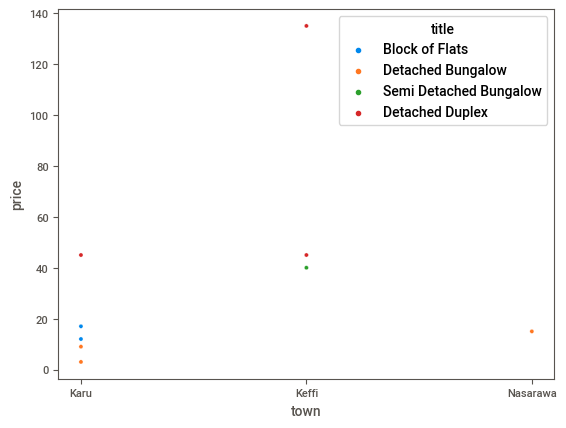

In [58]:
sns.scatterplot(data=nasarawa, x="town", y="price", hue="title")

In [82]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [144]:
model_xgb = XGBRegressor(n_estimators=100)

In [145]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [146]:
model_xgb.score(X_train, y_train)

0.6859829794071972

In [147]:
y_pred = model_xgb.predict(X_train)

In [148]:
y_pred

array([4.7971635, 4.1498976, 4.390042 , ..., 4.33283  , 3.68152  ,
       3.5384417], dtype=float32)

In [149]:
y_train

9052     4.317488
21352    4.317488
4123     4.317488
11814    4.382027
1055     4.442651
           ...   
13532    3.091042
12021    3.951244
12546    4.007333
1517     3.688879
18081    3.218876
Name: price, Length: 7143, dtype: float64

In [150]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error

In [151]:
mean_absolute_error(y_true=y_train, y_pred=y_pred)

0.2560512338205891

In [152]:
mean_squared_error(y_true=y_train, y_pred=y_pred)

0.11317028982084332

In [153]:
root_mean_squared_error(y_true=y_train, y_pred=y_pred)

0.3364079217569695

In [166]:
mean_absolute_percentage_error(y_train, y_pred)

0.06115237835081933

In [155]:
r2_score(y_true=y_train, y_pred=y_pred)

0.6859829794071972

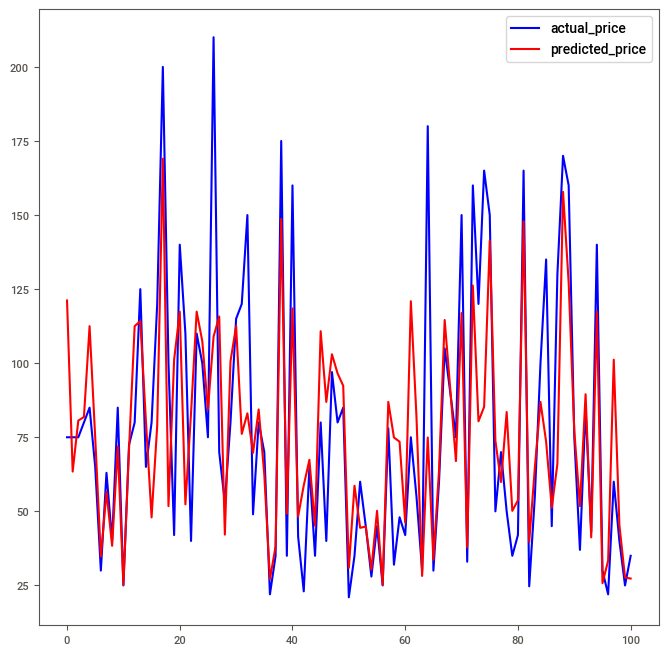

In [167]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(0,101), list(np.exp(y_train))[:101], color="blue", label="actual_price")
plt.plot(np.arange(0,101), np.exp(y_pred[:101]), color="red", label="predicted_price")
plt.legend()
plt.show()

In [157]:
y_pred_t = model_xgb.predict(X_test)

In [158]:
mean_absolute_error(y_test, y_pred_t)

0.30447798916014185

In [159]:
mean_squared_error(y_true=y_test, y_pred=y_pred_t)

0.1555464829731225

In [160]:
root_mean_squared_error(y_true=y_test, y_pred=y_pred_t)

0.3943938171081318

In [161]:
mean_absolute_percentage_error(y_test, y_pred_t)

0.07283097831249653

In [162]:
r2_score(y_true=y_test, y_pred=y_pred_t)

0.549290589167699

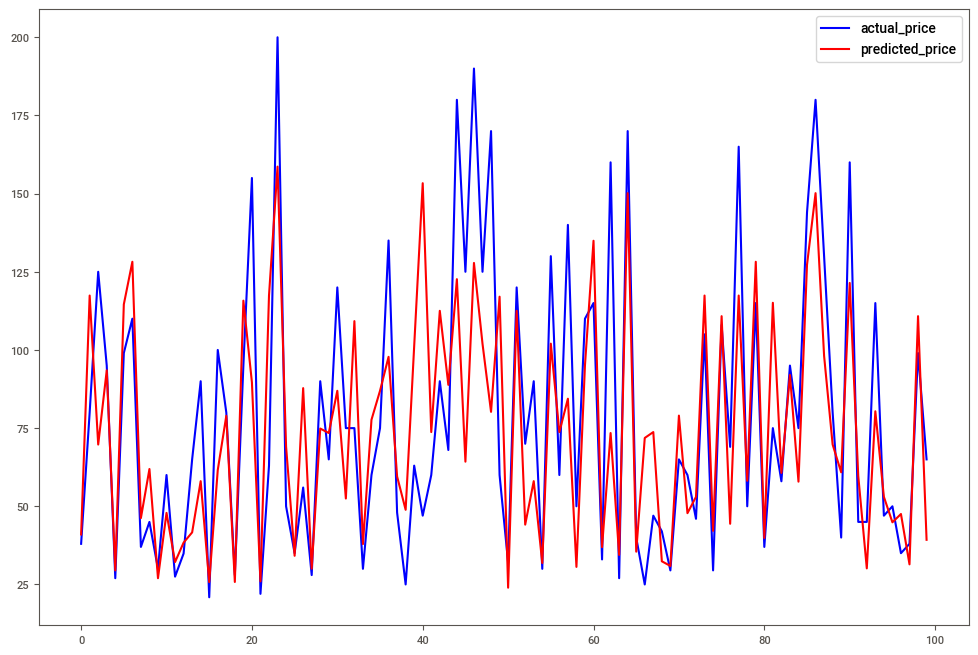

In [169]:
plt.figure(figsize=(12,8))
plt.plot(list(np.exp(y_test))[:100], color="blue", label="actual_price")
plt.plot(np.exp(y_pred_t[:100]), color="red", label="predicted_price")
plt.legend()
plt.show()

In [164]:
jl.dump(model_xgb, "model.pkl")

['model.pkl']

In [165]:
jl.dump(scaler, "scaler.pkl")

['scaler.pkl']